In [3]:
from sklearn import datasets, model_selection
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import *

In [4]:
def scatter_dataset(X,y):
    for i in range(int(np.max(y))+1):
        plt.scatter(X[y==i][:,0],X_train[y==i][:,1],s=10)
        plt.scatter(X[y==i][:,0],X_train[y==i][:,1],s=10)
    plt.show()
    
    

def plot_contours(ax, model, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z[Z<0]=0
    Z[Z>0]=1
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, 1,**params)
    return out

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 2, x.max() + 2
    y_min, y_max = y.min() - 2, y.max() + 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy    

In [96]:
class Model ():
    
    def __init__(self, sess, batch_size = 100, x_dim=2, nb_class = 2, lr_d = 0.01, lr_g = 0.01,
                 z_dim = 2, print_frequency=199, nb_epoch = 100,verbose=True):
        self.sess = sess
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.nb_class = nb_class
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        self.verbose = verbose
        self.print_frequency = print_frequency
        self.lr_d = lr_d
        self.lr_g = lr_g
        
        self.build_model()

    def generator(self, z, reuse=False):
        with tf.variable_scope("generator") as scope:
            if reuse:
                scope.reuse_variables()
            h = tf.layers.dense(z,20, activation=tf.nn.relu)
            h = tf.layers.dense(h,self.x_dim)
            return h

    def discriminator(self, inp, reuse=False):
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()
            h = tf.layers.dense(inp,40, activation=tf.nn.relu)
            h = tf.layers.dense(h,20, activation=tf.nn.relu)
            layer = h
            h = tf.layers.dense(h,self.nb_class)
            return h, layer

    def build_model(self):
        self.lab = tf.placeholder(tf.float32,[None,self.x_dim], name='input_lbl_data')
        self.unl = tf.placeholder(tf.float32,[None,self.x_dim], name='input_unl_data')
        self.z = tf.placeholder(tf.float32, [None,self.z_dim],name='z_seed')
        self.lbl = tf.placeholder(tf.int32, [None],name='labels')
         
        self.gen = self.generator(self.z,reuse=False)
        self.l_lab, _ = self.discriminator(self.lab, reuse=False)
        self.l_unl, self.layer_r = self.discriminator(self.unl, reuse=True)
        self.l_fake, self.layer_f = self.discriminator(self.gen, reuse=True)
        
        #loss discriminator
        self.loss_lab = - tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.l_lab,labels=self.lbl))
        self.d_loss_fake = 0.5 * tf.reduce_mean(tf.nn.softplus(tf.reduce_logsumexp(self.l_fake)))
        self.d_loss_real = - 0.5 * tf.reduce_mean(self.l_unl) + 0.5 * tf.reduce_mean(tf.nn.softplus(tf.reduce_logsumexp(self.l_unl)))
        self.d_loss = self.d_loss_fake + self.d_loss_real
        #loss generator
        self.fm_loss = tf.reduce_mean(tf.reduce_mean(tf.abs(self.layer_r-self.layer_f),axis=0))
        
        self.prediction = tf.cast(tf.argmax(self.lab,1),tf.int32)                                 
        self.correct_prediction = tf.equal(tf.argmax(self.lab, 1), tf.argmax(tf.one_hot(self.lbl, depth=self.nb_class), 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'discriminator' in var.name]
        self.g_vars = [var for var in t_vars if 'generator' in var.name]    
        self.d_optim = tf.train.AdamOptimizer(self.lr_d).minimize(loss=self.d_loss, var_list=self.d_vars)
        self.g_optim = tf.train.AdamOptimizer(self.lr_g).minimize(loss=self.fm_loss, var_list=self.g_vars)
        

    def train(self, X_unl,X_lab, y, X_test,y_test):
        self.X_unl = X_unl
        self.X_unl2 = X_unl.copy()
        self.y = y
        self.X_lab = X_lab
        self.X_test = X_test
        self.y_test = y_test
                                         
        self.nb_examples = self.X_unl.shape[0]
        self.nb_step = self.nb_examples//self.batch_size
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch in range(self.nb_epoch):
            for step in range(self.nb_step):               
                trainx = []
                trainy = []
                for t in range(X_unl.shape[0]//X_lab.shape[0]):
                    inds = np.random.permutation(X_lab.shape[0])
                    trainx.append(X_lab[inds])
                    trainy.append(y[inds])
                self.X_lab = np.concatenate(trainx, axis=0)
                self.y = np.concatenate(trainy, axis=0)
                self.X_unl = self.X_unl[np.random.permutation(self.X_unl.shape[0])]
                self.X_unl2 = self.X_unl2[np.random.permutation(self.X_unl2.shape[0])]

                ll_d = 0
                ll_g = 0 
                for step in range(self.nb_step):
                    ran_from = step * self.batch_size
                    ran_to = (step+1) * self.batch_size
                    _, ll = self.sess.run([self.d_optim, self.d_loss],feed_dict={self.lab:self.X_lab[ran_from:ran_to],
                                                                            self.lbl:self.y[ran_from:ran_to],
                                                                            self.unl:self.X_unl[ran_from:ran_to],
                                                                            self.z:np.random.randn(self.batch_size,self.z_dim)})
                    ll_d += ll
                    
                    _, ll = self.sess.run([self.g_optim, self.fm_loss],feed_dict={self.unl:self.X_unl2[ran_from:ran_to],
                                                                             self.z:np.random.randn(self.batch_size,self.z_dim)})
                    ll_g += ll
                ll_d /= (self.nb_examples//self.nb_step)
                ll_g /= (self.nb_examples//self.nb_step)     
                                           
            if (epoch % self.print_frequency == 0) & (self.verbose == True):
                train_acc = self.sess.run(self.accuracy,feed_dict={self.lab:self.X_lab, self.lbl:self.y})
                test_acc = self.sess.run(self.accuracy,feed_dict={self.lab:self.X_test, self.lbl:self.y_test})

                print('epoch %d | loss d = %0.4f | loss g = %0.4f | train acc = %0.4f | test acc = %0.4f '
                      %(epoch, ll_d, ll_g, train_acc, test_acc))

    def predict(self, X_test, y_test=None):
        if y_test == None:     
            pred = self.sess.run(self.prediction ,feed_dict={self.lab:X_test[:]})
            return pred
                                         
        return self.sess.run([self.prediction, self.accuracy],feed_dict={self.lab:X_test,
                                                                         self.lbl:y_test})
                                 

    def generate_random_samples(self, nb_samples):
        return self.sess.run(self.gen,feed_dict={self.z:np.random.randn(nb_samples,self.z_dim)})                      

In [97]:
X,y = datasets.make_moons(n_samples=1000,noise=0.01)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
nb_labels = 5
X_train_lab = np.concatenate([X_train[y_train==0][:nb_labels],X_train[y_train==1][:nb_labels]])
y_train_lab = np.concatenate([np.zeros(nb_labels),np.ones(nb_labels)]) 

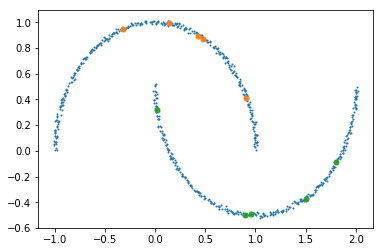

In [98]:
plt.scatter(X_train[:,0] ,X_train[:,1], s=1)
plt.scatter(X_train_lab[y_train_lab==0][:,0],X_train_lab[y_train_lab==0][:,1],s=25)
plt.scatter(X_train_lab[y_train_lab==1][:,0],X_train_lab[y_train_lab==1][:,1],s=25)
plt.show()

In [99]:
train_unl = X_train
trainx = X_train_lab

In [104]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
ssgan = Model(sess, nb_epoch=2000, lr_g=0, lr_d=0.001)

In [105]:
ssgan.train(train_unl, trainx, y_train_lab,X_test,y_test)

epoch 0 | loss d = 0.2779 | loss g = 0.0045 | train acc = 0.2000 | test acc = 0.1879 
epoch 199 | loss d = 0.1541 | loss g = 0.0342 | train acc = 0.2000 | test acc = 0.1879 
epoch 398 | loss d = 0.1540 | loss g = 0.0374 | train acc = 0.2000 | test acc = 0.1879 
epoch 597 | loss d = 0.1530 | loss g = 0.0377 | train acc = 0.2000 | test acc = 0.1879 


KeyboardInterrupt: 

In [106]:
pred = ssgan.predict(X_train)

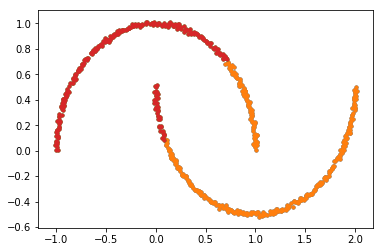

In [107]:
scatter_dataset(X_train,pred)